# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

CMAQDATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station"

PM_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
    "SO2_quantrac"
]

CMAQ_COLS = [
    "NO2_cmaq",
    "O3_cmaq",
    "SO2_cmaq"
]

BASE_FEATURE_COLS = PM_COLS + CMAQ_COLS

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
    f.write(f"RANDOM_STATE: {RANDOM_STATE}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_11-17_12_45


# Load dataset

## Method

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    elif "Date" in df.columns and "Time" in df.columns:
        df["date"] = pd.to_datetime((df["Date"] + " " + df["Time"]).astype('datetime64[ns]'), format="%y/%m/%d %H:%M:%S")
        df = df.drop(columns=["Date", "Time"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove "Unnamed" column
    for c in df.columns:
        if "Unnamed:" in c:
            df = df.drop(columns=[c])

    # Add station_id column
    if "Station" not in df.columns:
        df["station_id"] = station_id
    else:
        df = df.rename({"Station": "station_id"}, axis=1)
    return df

## CMAQ data

In [3]:
# Load dataset
dfs_cmaq = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, CMAQDATA_DIR)
    dfs_cmaq.append(df_sid)
df_cmaq = pd.concat(dfs_cmaq, ignore_index=True)

# Rename columns
df_cmaq = df_cmaq.rename({c: f"{c}_cmaq" for c in df_cmaq.columns if c not in ["date", "station_id"]}, axis=1)

# Sort data by station then date
df_cmaq = df_cmaq.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_cmaq = df_cmaq.loc[:, ["date"] + CMAQ_COLS + ["station_id"]]

display(df_cmaq)

# Convert unit
df_cmaq["NO2_cmaq"] = df_cmaq["NO2_cmaq"] * 1883.2
df_cmaq["O3_cmaq"] = df_cmaq["O3_cmaq"] * 1960
df_cmaq["SO2_cmaq"] = df_cmaq["SO2_cmaq"] * 2620

print(df_cmaq.shape)
print(df_cmaq.columns)
df_cmaq

,date,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.000072,0.096425,0.000027,211
1,2022-01-01 08:00:00,0.000074,0.077419,0.000038,211
2,2022-01-01 09:00:00,0.000055,0.061006,0.000050,211
3,2022-01-01 10:00:00,0.000040,0.048525,0.000057,211
4,2022-01-01 11:00:00,0.000034,0.029449,0.000047,211
...,...,...,...,...,...
44851,2022-12-31 01:00:00,0.002276,0.026421,0.000149,216
44852,2022-12-31 02:00:00,0.002208,0.026171,0.000148,216
44853,2022-12-31 03:00:00,0.002249,0.026087,0.000151,216
44854,2022-12-31 04:00:00,0.002680,0.026347,0.000166,216


(44856, 5)
Index(['date', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id'], dtype='object')


,date,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.136344,188.993157,0.071526,211
1,2022-01-01 08:00:00,0.138604,151.741122,0.100084,211
2,2022-01-01 09:00:00,0.104141,119.571595,0.130476,211
3,2022-01-01 10:00:00,0.075893,95.109490,0.149078,211
4,2022-01-01 11:00:00,0.063087,57.721016,0.122092,211
...,...,...,...,...,...
44851,2022-12-31 01:00:00,4.285888,51.784937,0.389183,216
44852,2022-12-31 02:00:00,4.157322,51.295325,0.386550,216
44853,2022-12-31 03:00:00,4.235773,51.130547,0.394695,216
44854,2022-12-31 04:00:00,5.047855,51.640614,0.435544,216


## PM data

In [4]:
# Load dataset
dfs_pm = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs_pm.append(df_sid)
df_pm = pd.concat(dfs_pm, ignore_index=True)

# Sort data by station then date
df_pm = df_pm.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_pm = df_pm.loc[:, ["date"] + PM_COLS + ["station_id"]]

print(df_pm.shape)
print(df_pm.columns)
df_pm

(92966, 9)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,NaN,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,NaN,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,NaN,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,NaN,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,NaN,211
...,...,...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,27.690000,67.290000,0.105667,216
92962,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,27.401667,68.026667,0.104167,216
92963,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,27.603333,66.965000,0.130167,216
92964,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,27.036667,63.361667,0.075833,216


## Merge 2 data

In [5]:
dfs_all = []
for station in STATION_IDS:
    df_pm_station = df_pm[df_pm["station_id"] == station]
    df_cmaq_station = df_cmaq[df_cmaq["station_id"] == station]
    df_joined = pd.merge(df_pm_station.drop(columns=["station_id"]), df_cmaq_station, on='date', how='inner')
    dfs_all.append(df_joined)
df_all = pd.concat(dfs_all, axis=0).reset_index(drop=True)
df_all

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,90.000000,22.783333,35.588975,756.627400,24.661667,73.355000,NaN,0.136344,188.993157,0.071526,211
1,2022-01-01 08:00:00,90.000000,21.883333,55.011077,749.102000,27.258333,65.521667,NaN,0.138604,151.741122,0.100084,211
2,2022-01-01 09:00:00,90.000000,16.233333,64.729197,727.519000,29.250000,57.910000,NaN,0.104141,119.571595,0.130476,211
3,2022-01-01 10:00:00,90.000000,15.700000,75.109218,721.196900,30.676667,53.673333,NaN,0.075893,95.109490,0.149078,211
4,2022-01-01 11:00:00,74.207348,15.650000,77.767804,722.056400,32.168333,49.080000,NaN,0.063087,57.721016,0.122092,211
...,...,...,...,...,...,...,...,...,...,...,...,...
43370,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216
43371,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216
43372,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216
43373,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216


In [6]:
df_all.isnull().sum()

date                        0
NO2_quantrac            27391
PM25_quantrac           27393
O3_quantrac             30277
CO_quantrac             27407
Temperature_quantrac    35140
Humid_quantrac          35140
SO2_quantrac            28944
NO2_cmaq                    0
O3_cmaq                     0
SO2_cmaq                    0
station_id                  0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [7]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.081167,24.380000,60.100000,1.716167,25.045000,68.216667,0.100833,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,0.080950,22.648333,63.233333,2.143833,25.775000,66.696667,0.128833,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,0.077917,22.331667,66.700000,2.194833,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,0.067467,24.293333,71.166667,1.860500,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,0.038431,24.360345,53.982759,1.923966,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216


## Update the STATION_IDS after dropping missing

In [8]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[216]

## Visualization

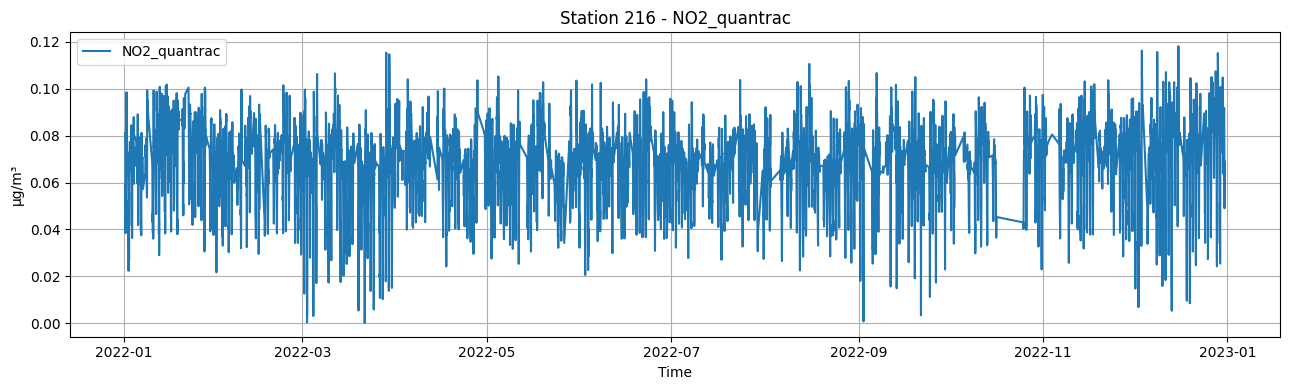

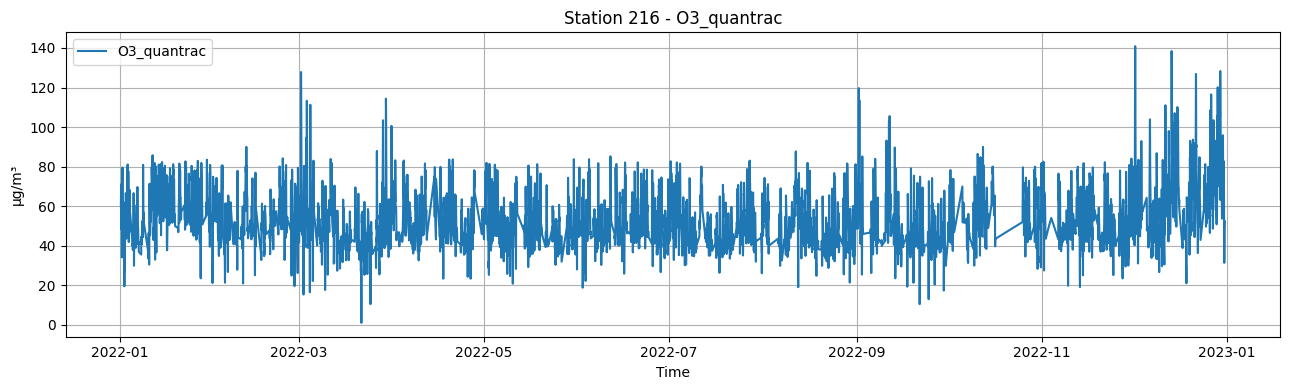

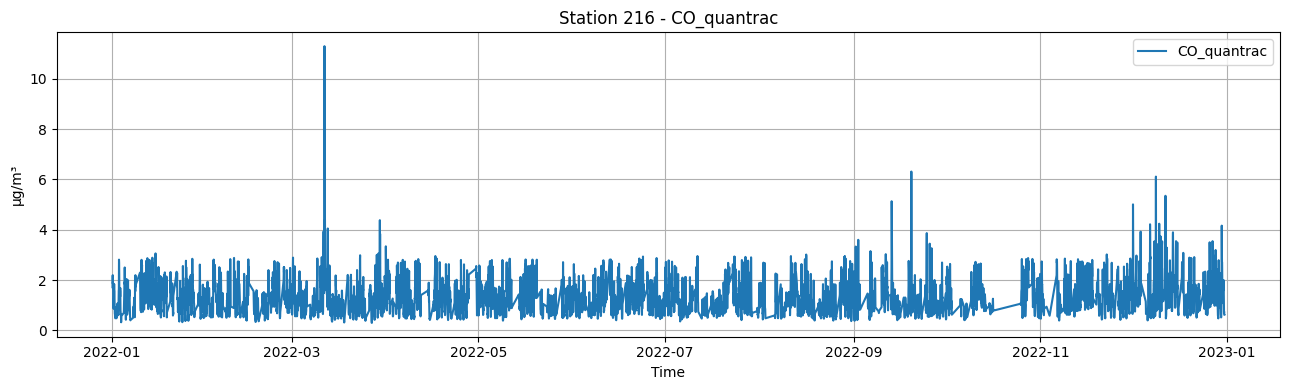

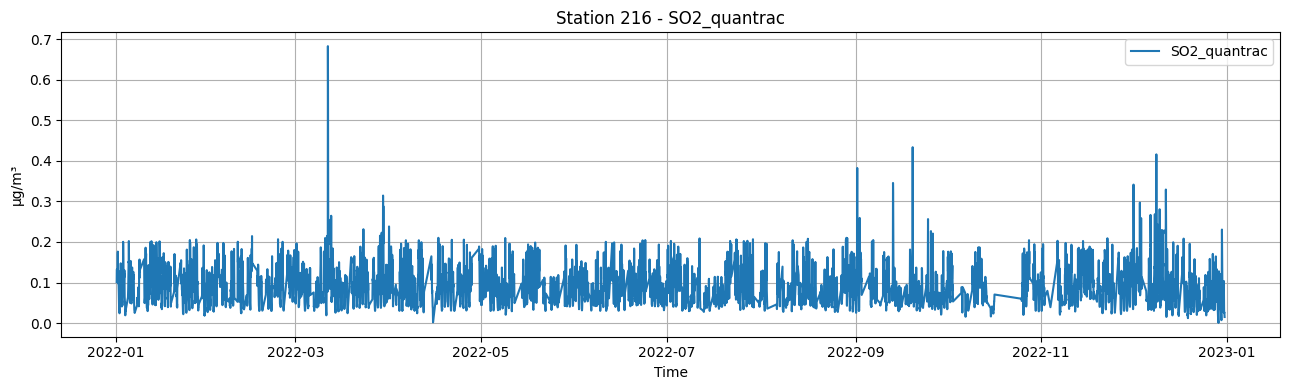

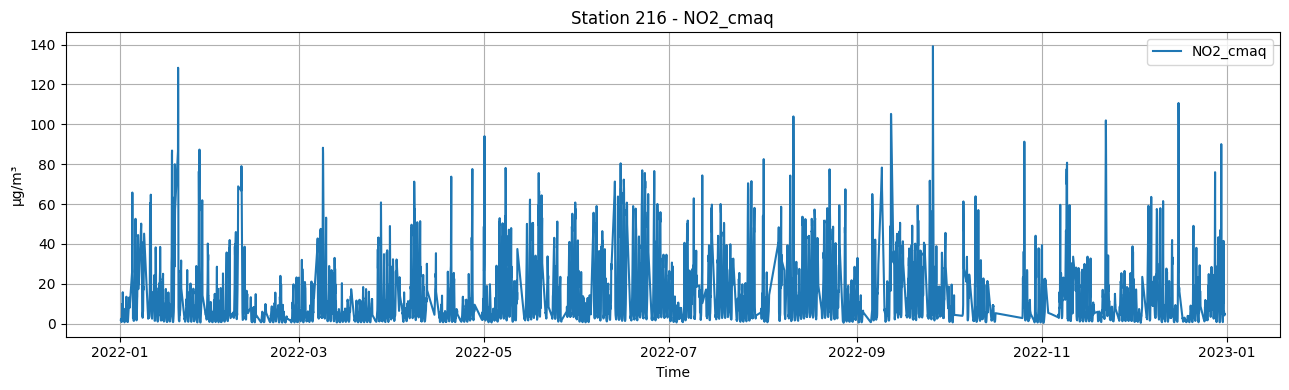

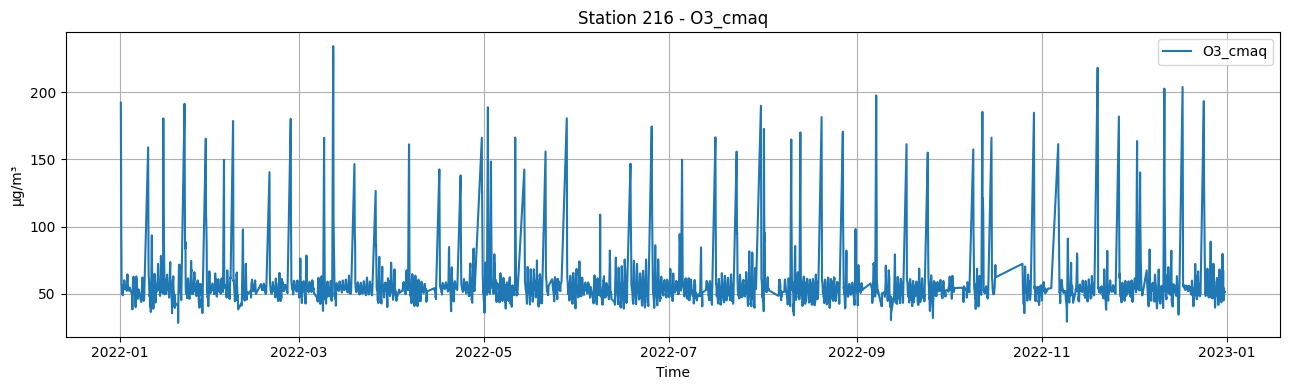

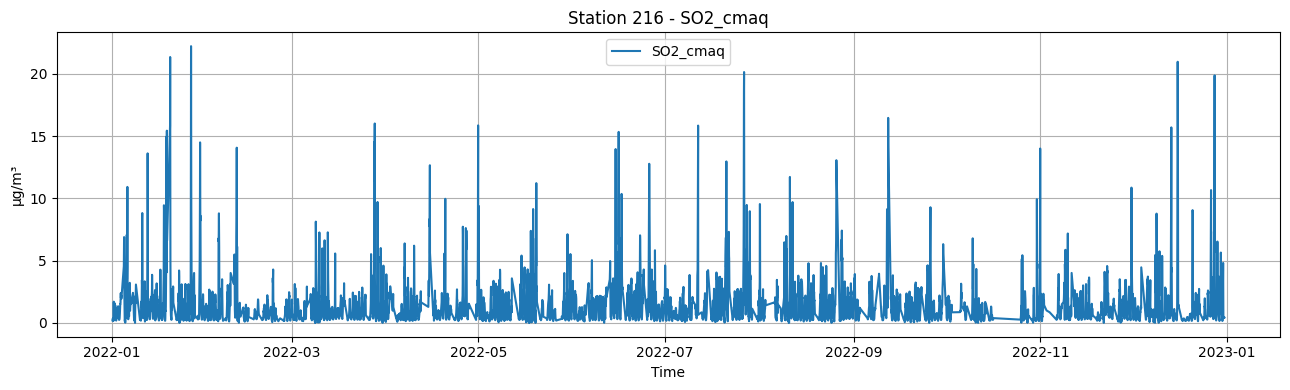

In [9]:
def plot_1_data(df, target_col, label, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df[target_col], label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [10]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,152.853067,24.380000,60.100000,1968.099933,25.045000,68.216667,0.100833,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,152.445040,22.648333,63.233333,2458.548067,25.775000,66.696667,0.128833,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,146.732667,22.331667,66.700000,2517.034867,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,127.053227,24.293333,71.166667,2133.621400,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,72.373324,24.360345,53.982759,2206.403655,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,92.346548,17.709259,31.425926,945.048148,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,119.184217,22.803390,43.220339,822.974780,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,130.034960,23.031667,48.866667,855.703933,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,121.654720,22.331667,50.633333,708.340133,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216


## Visualization after converting unit

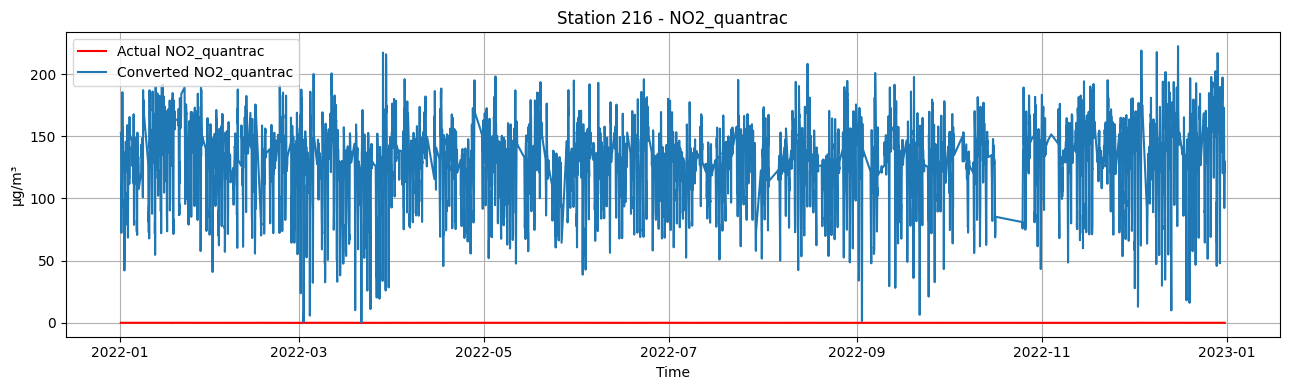

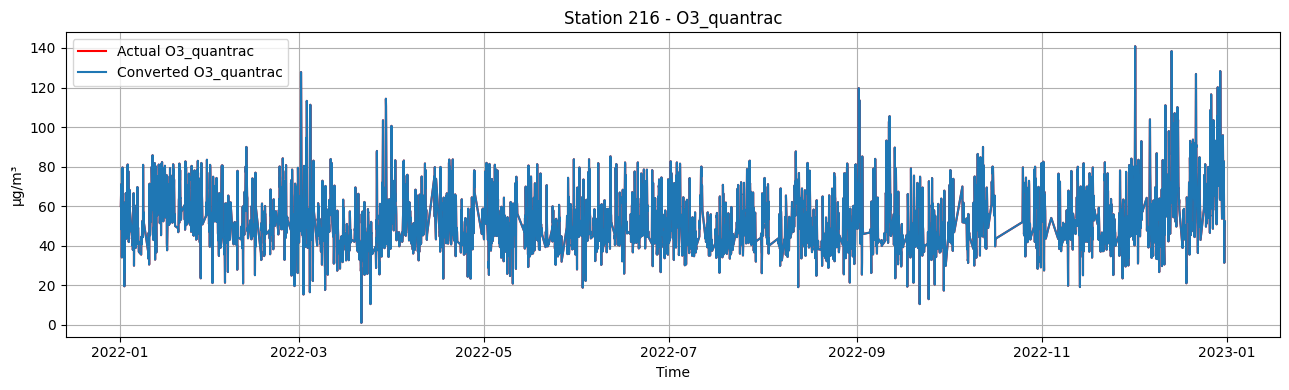

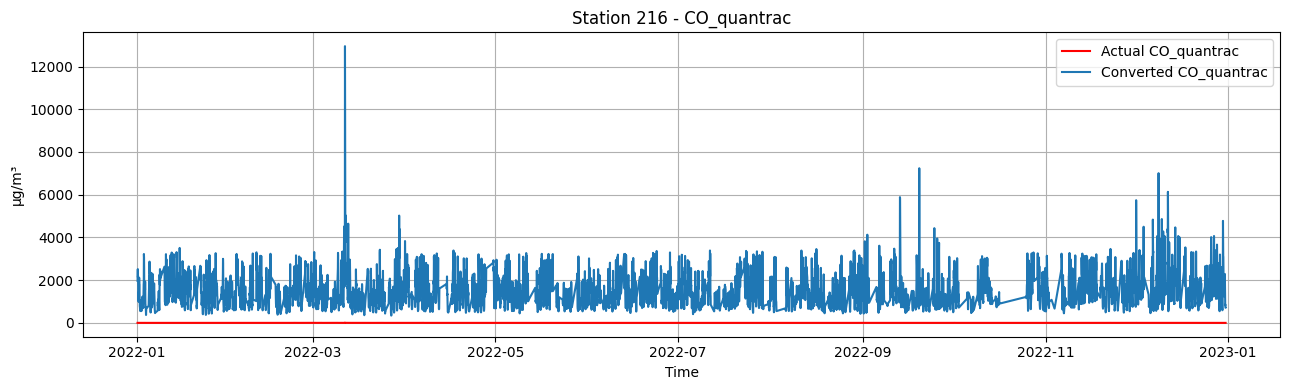

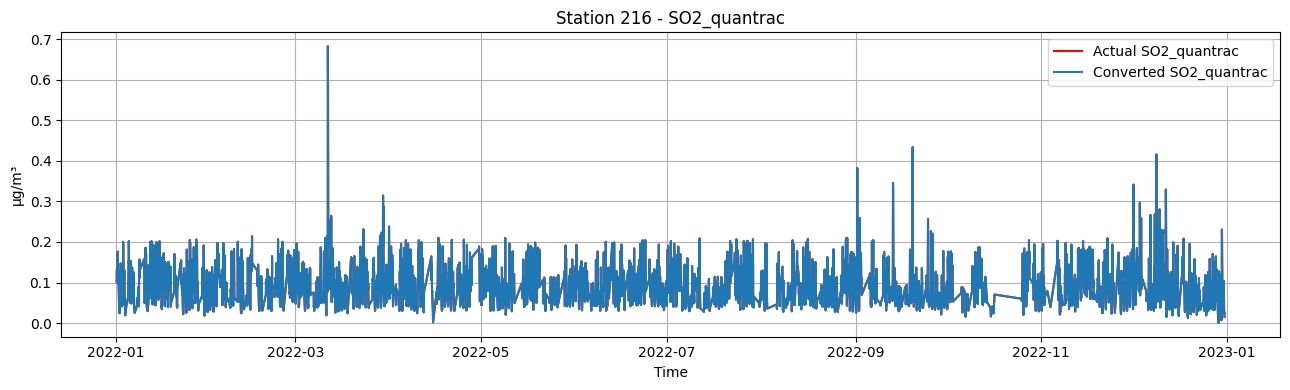

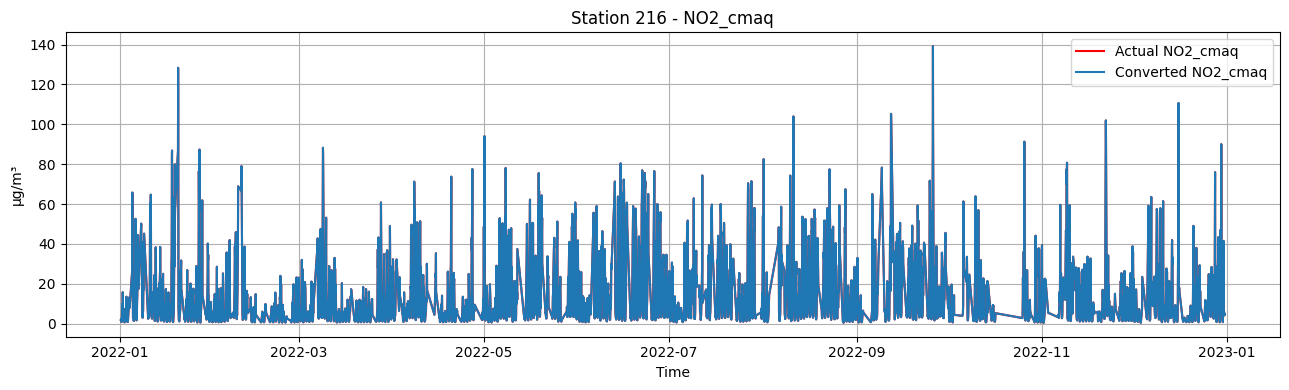

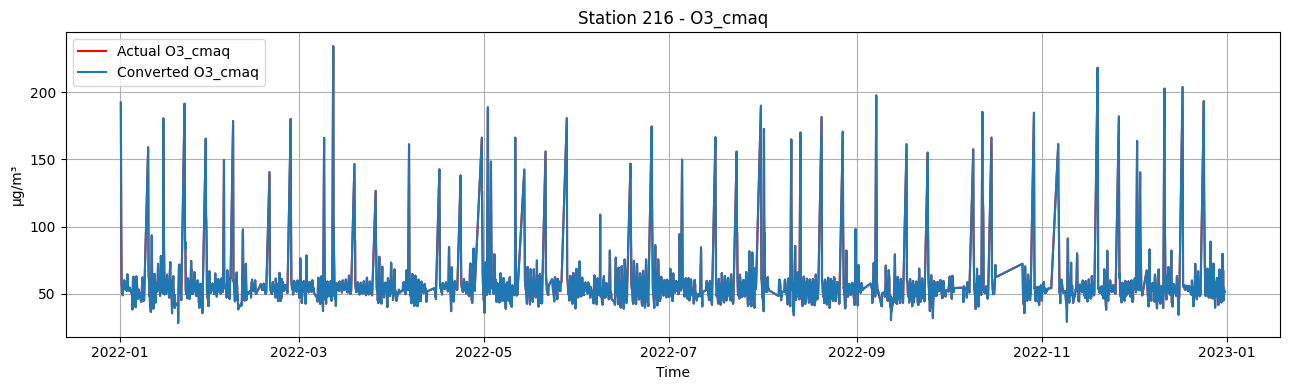

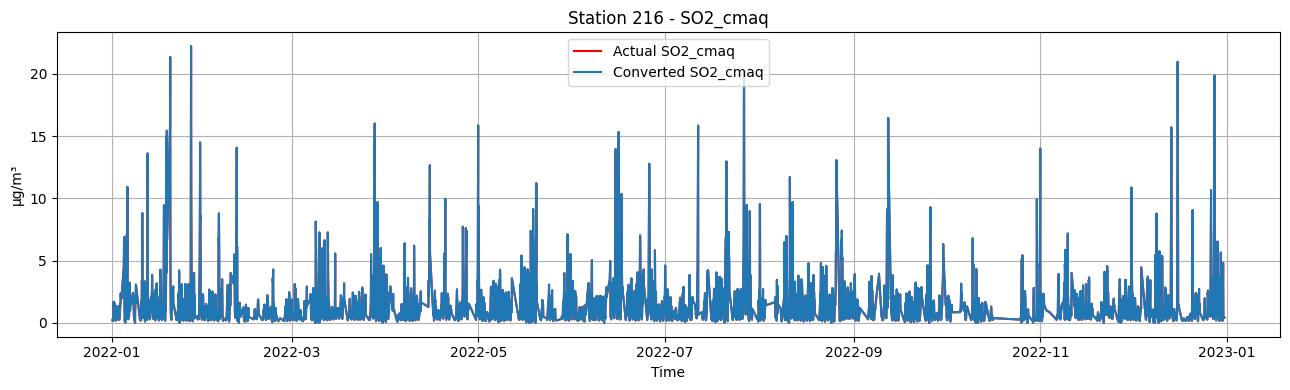

In [11]:
def plot_2_data(df1, target_col1, label1, df2, target_col2, label2, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df1[target_col1], label=label1, color="r")
    plt.plot(index, df2[target_col2], label=label2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [12]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 6680 records
After: 6678 records
Removed 2 records


## Visualization after removing outliers

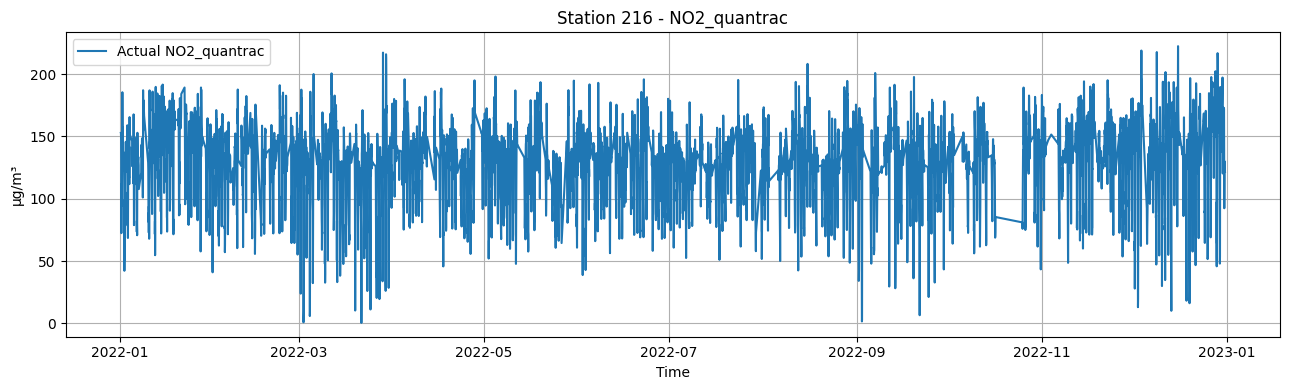

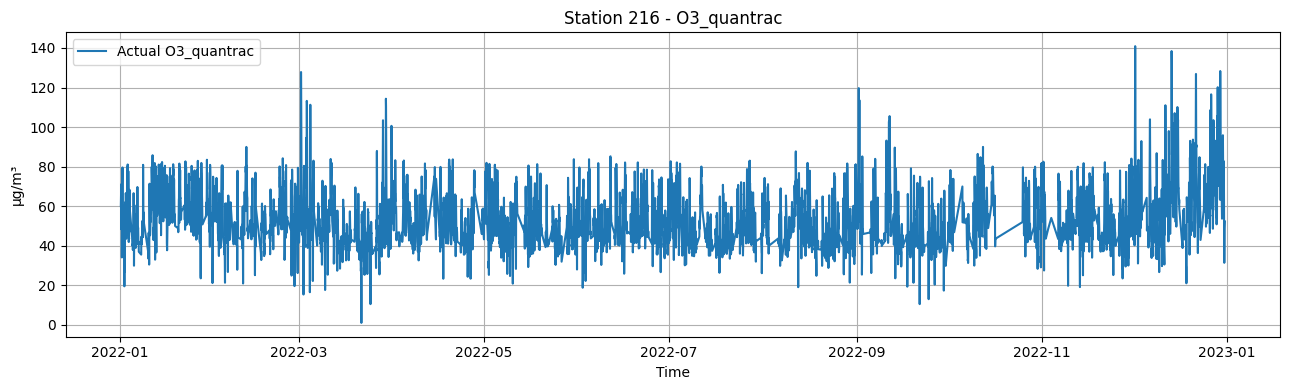

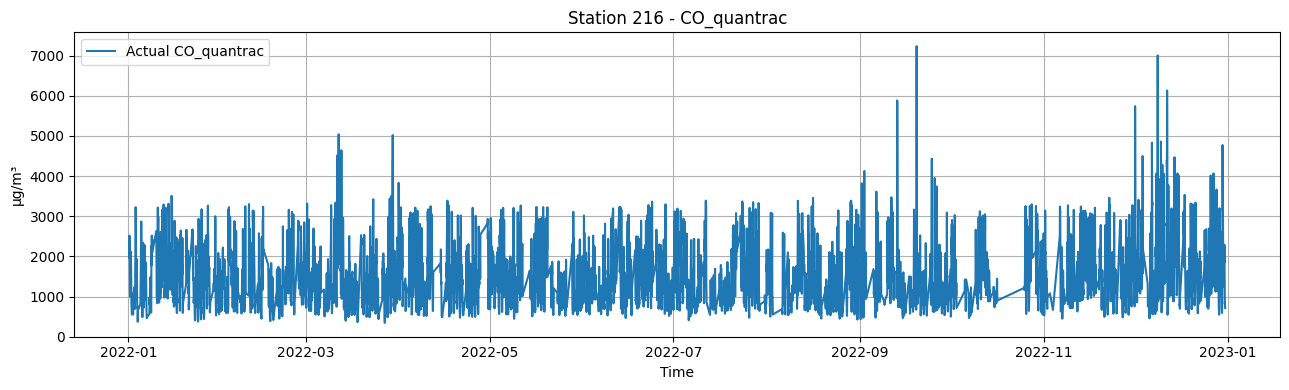

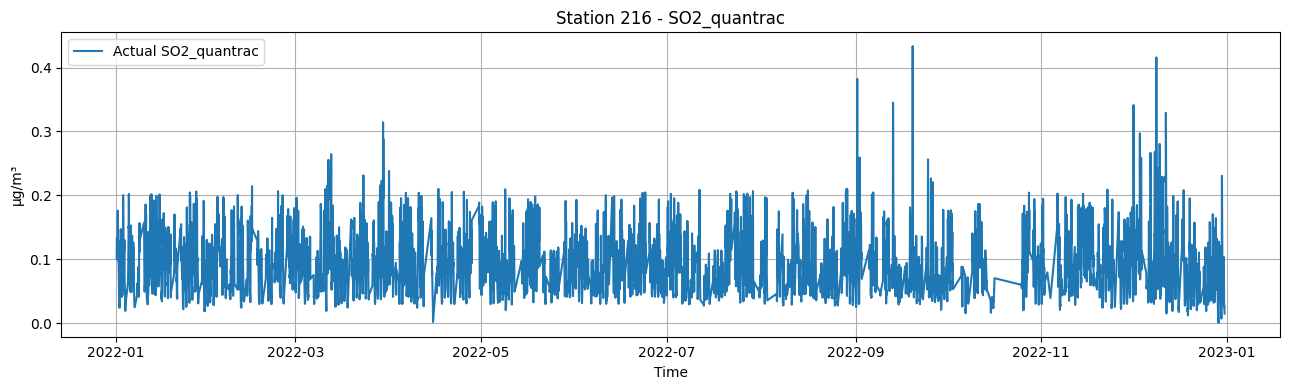

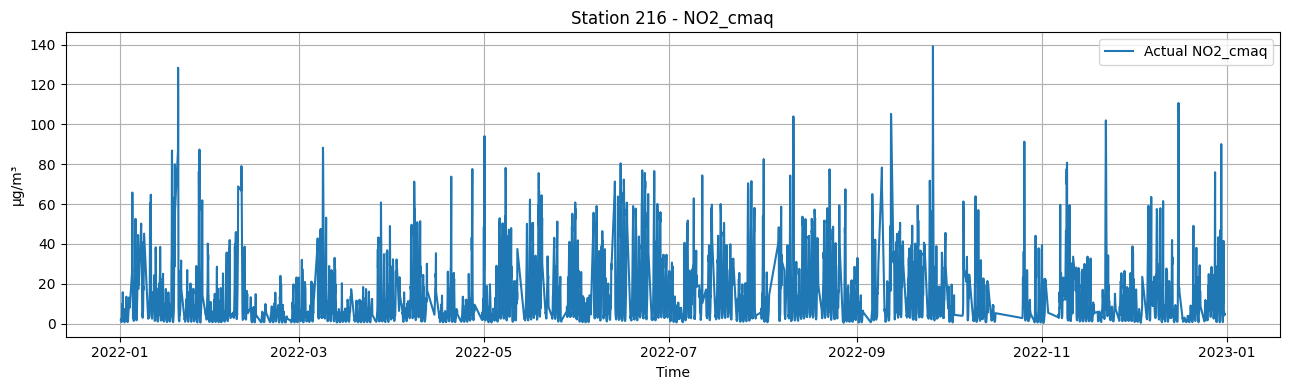

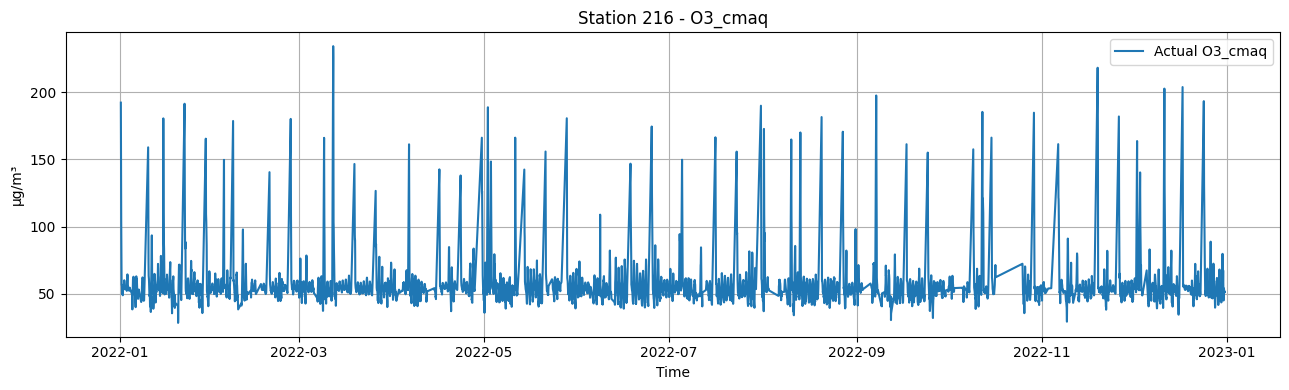

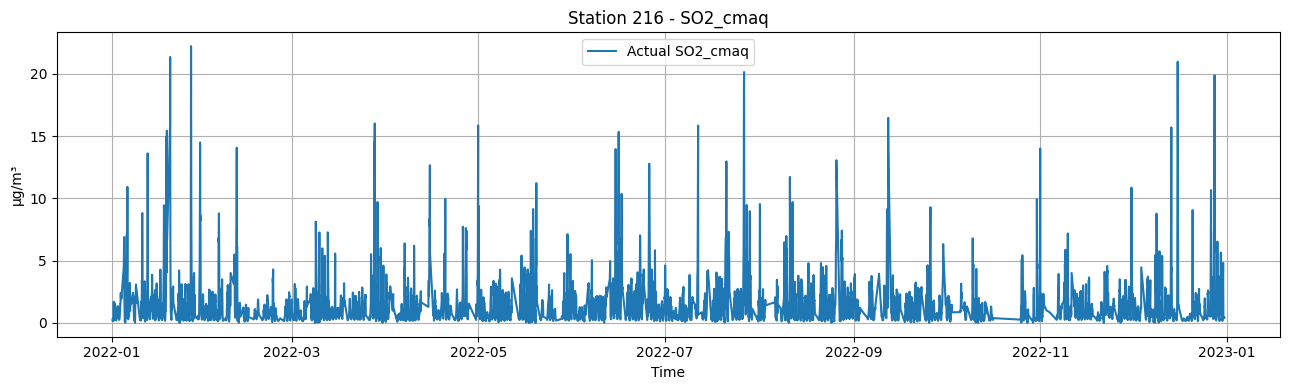

In [13]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [14]:
def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

# Add lag features for all FEATURES including LABEL
def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

# Just add the rolling features for LABEL
def add_rolling_features(df, group_col, target_cols, windows):
    assert isinstance(target_cols, list), "target_cols should be a list"

    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1) # use the past, avoid leaking
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO2_quantrac"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(6678, 20)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'NO2_cmaq',
       'O3_cmaq', 'SO2_cmaq', 'station_id', 'NO2_quantrac_roll3_mean',
       'NO2_quantrac_roll3_std', 'NO2_quantrac_roll6_mean',
       'NO2_quantrac_roll6_std', 'NO2_quantrac_roll12_mean',
       'NO2_quantrac_roll12_std', 'NO2_quantrac_roll24_mean',
       'NO2_quantrac_roll24_std'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 07:00:00,152.853067,24.380000,60.100000,1968.099933,25.045000,68.216667,0.100833,1.847962,192.197659,0.202002,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 08:00:00,152.445040,22.648333,63.233333,2458.548067,25.775000,66.696667,0.128833,2.436309,156.783693,0.274170,216,152.853067,NaN,152.853067,NaN,152.853067,NaN,152.853067,NaN
2,2022-01-01 09:00:00,146.732667,22.331667,66.700000,2517.034867,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,216,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518
3,2022-01-01 10:00:00,127.053227,24.293333,71.166667,2133.621400,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,216,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914
4,2022-01-01 11:00:00,72.373324,24.360345,53.982759,2206.403655,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,216,142.076978,13.320759,144.771000,12.137797,144.771000,12.137797,144.771000,12.137797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6673,2022-12-31 01:00:00,92.346548,17.709259,31.425926,945.048148,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216,162.467849,16.160517,167.076458,11.438594,151.443282,20.588002,157.199778,20.786118
6674,2022-12-31 02:00:00,119.184217,22.803390,43.220339,822.974780,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216,136.126298,40.487158,154.120158,32.318802,149.118635,25.435481,154.467975,24.639817
6675,2022-12-31 03:00:00,130.034960,23.031667,48.866667,855.703933,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216,118.448157,25.741473,145.145079,33.472296,146.514295,26.848976,153.499776,25.572650
6676,2022-12-31 04:00:00,121.654720,22.331667,50.633333,708.340133,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216,113.855242,19.401097,138.161545,31.048054,145.117588,27.265733,152.945279,25.944042


## Build supervised from time-series

In [15]:
# Reframe past future
def build_supervised_for_horizon(df, horizon_h, target_col):
    # Sort data by station_id then date
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    # Define target_name, which is the target_col plus horizon_h hour
    target_name = f"{target_col}_t_plus_{horizon_h}h"
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)

    # Dropna after shifting
    df = df.dropna().reset_index(drop=True)

    # Define label, feature and meta columns
    label_cols = [target_name]
    meta_cols = ["date", "station_id"]
    feature_cols = [c for c in df.columns if c not in label_cols + meta_cols + [target_col]]

    # Get the X, y and meta data
    X = df[meta_cols + feature_cols]
    y = df[meta_cols + label_cols]

    return X, y

# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (6604, 19) (6604, 3)
Index(['date', 'station_id', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'NO2_cmaq',
       'O3_cmaq', 'SO2_cmaq', 'NO2_quantrac_roll3_mean',
       'NO2_quantrac_roll3_std', 'NO2_quantrac_roll6_mean',
       'NO2_quantrac_roll6_std', 'NO2_quantrac_roll12_mean',
       'NO2_quantrac_roll12_std', 'NO2_quantrac_roll24_mean',
       'NO2_quantrac_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_quantrac_t_plus_72h'], dtype='object')


,date,station_id,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 09:00:00,216,22.331667,66.700000,2517.034867,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518
1,2022-01-01 10:00:00,216,24.293333,71.166667,2133.621400,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914
2,2022-01-01 11:00:00,216,24.360345,53.982759,2206.403655,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,142.076978,13.320759,144.771000,12.137797,144.771000,12.137797,144.771000,12.137797
3,2022-01-01 12:00:00,216,22.908333,48.333333,1527.728733,33.625000,45.271667,0.111667,0.817503,63.247973,0.170824,115.386406,38.528093,130.291465,34.040847,130.291465,34.040847,130.291465,34.040847
4,2022-01-01 13:00:00,216,28.223333,70.116667,1153.489667,34.278333,46.648333,0.103667,0.832625,56.665207,0.159558,95.843693,28.149493,123.260309,34.980657,123.260309,34.980657,123.260309,34.980657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,2022-12-27 23:00:00,216,33.321667,74.233333,1633.998867,26.328333,72.273333,0.055000,59.889300,43.220554,19.342058,175.022516,8.106778,164.314431,13.193297,147.852124,21.787281,162.720373,23.374430
6600,2022-12-28 00:00:00,216,29.511667,76.966667,1122.526067,25.923333,75.600000,0.033167,75.965866,39.656935,19.869703,174.781884,8.519693,166.412107,11.862084,149.159902,22.348334,162.637983,23.362139
6601,2022-12-28 01:00:00,216,36.455000,71.900000,1250.967667,25.563333,78.383333,0.041833,30.314140,41.167530,4.664907,168.263920,11.260467,168.033751,9.469346,151.461591,21.762316,161.247815,22.494585
6602,2022-12-28 02:00:00,216,53.257407,65.388889,2324.818444,25.151852,79.572222,0.090556,6.613904,44.155574,0.802737,161.955200,3.029911,168.488858,9.010355,155.094598,19.205420,159.987117,21.515841


,date,station_id,NO2_quantrac_t_plus_72h
0,2022-01-01 09:00:00,216,138.572133
1,2022-01-01 10:00:00,216,140.926133
2,2022-01-01 11:00:00,216,140.831973
3,2022-01-01 12:00:00,216,135.150987
4,2022-01-01 13:00:00,216,140.078693
...,...,...,...
6599,2022-12-27 23:00:00,216,92.346548
6600,2022-12-28 00:00:00,216,119.184217
6601,2022-12-28 01:00:00,216,130.034960
6602,2022-12-28 02:00:00,216,121.654720


## Split train/validation/test for each station

In [16]:
def train_test_validation_split(X, y, train_ratio=0.7, val_ratio=0.15):
    assert (X["date"].equals(y["date"]) and X["station_id"].equals(y["station_id"])), "X and y should have the same metadata values"

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    meta_train, meta_val, meta_test = [], [], []

    meta_cols = ["date", "station_id"]
    
    for station in list(sorted(X["station_id"].unique())):
        X_station = X[X["station_id"] == station]
        y_station = y[y["station_id"] == station]
        meta = X_station[meta_cols]

        X_station = X_station.drop(columns=meta_cols)
        y_station = y_station.drop(columns=meta_cols)
    
        n = len(X_station)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
    
        X_train.append(X_station.iloc[:train_end])
        y_train.append(y_station.iloc[:train_end])
        meta_train.append(meta.iloc[:train_end])
    
        X_val.append(X_station.iloc[train_end:val_end])
        y_val.append(y_station.iloc[train_end:val_end])
        meta_val.append(meta.iloc[train_end:val_end])
    
        X_test.append(X_station.iloc[val_end:])
        y_test.append(y_station.iloc[val_end:])
        meta_test.append(meta.iloc[val_end:])

    X_train = pd.concat(X_train, axis=0)
    X_val = pd.concat(X_val, axis=0)
    X_test = pd.concat(X_test, axis=0)
    
    y_train = pd.concat(y_train, axis=0)
    y_val = pd.concat(y_val, axis=0)
    y_test = pd.concat(y_test, axis=0)
    
    meta_train = pd.concat(meta_train, axis=0)
    meta_val = pd.concat(meta_val, axis=0)
    meta_test = pd.concat(meta_test, axis=0)

    return (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test)

# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
5613,16.905000,41.616667,2169.363333,26.231667,94.508333,0.129167,7.664134,59.761239,0.745196,144.891316,6.007111,150.581087,8.614717,148.539177,7.447143,140.211667,11.279129
5614,19.085000,47.166667,2978.621867,27.033333,90.061667,0.170167,2.736450,66.583446,0.459155,144.253120,6.322291,148.814649,9.281174,148.369165,7.591408,141.348126,9.837897
5615,14.083333,46.150000,2427.202200,28.890000,80.045000,0.139333,2.774031,75.919355,0.470617,146.753591,4.958729,145.911382,5.153970,148.471172,7.564553,142.331575,9.141731
5616,11.178333,44.866667,1825.514467,30.341667,75.125000,0.108333,2.794396,85.499343,0.508309,137.682844,11.959281,141.287080,9.339836,146.993383,10.213483,141.940549,9.712366
5617,12.308333,42.400000,1549.135667,31.895000,70.036667,0.094167,2.072558,91.054865,0.661275,127.220622,18.679269,135.736871,15.575184,144.330748,14.748784,141.042106,11.523420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,33.321667,74.233333,1633.998867,26.328333,72.273333,0.055000,59.889300,43.220554,19.342058,175.022516,8.106778,164.314431,13.193297,147.852124,21.787281,162.720373,23.374430
6600,29.511667,76.966667,1122.526067,25.923333,75.600000,0.033167,75.965866,39.656935,19.869703,174.781884,8.519693,166.412107,11.862084,149.159902,22.348334,162.637983,23.362139
6601,36.455000,71.900000,1250.967667,25.563333,78.383333,0.041833,30.314140,41.167530,4.664907,168.263920,11.260467,168.033751,9.469346,151.461591,21.762316,161.247815,22.494585
6602,53.257407,65.388889,2324.818444,25.151852,79.572222,0.090556,6.613904,44.155574,0.802737,161.955200,3.029911,168.488858,9.010355,155.094598,19.205420,159.987117,21.515841


## Metrics

In [17]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Bias Error
    mbe = np.mean(y_pred - y_true)

    # MNBE
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    mnbe = np.nanmean((y_pred - yt_nonzero) / yt_nonzero) * 100.0

    # Pearson r (with standard deviation check)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true.T, y_pred.T)[0, 1]

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MBE": mbe,
        "MNBE": mnbe,
        "r": r,
        "n_samples": len(y_true),
    }

# LightGBM model

## Define model

In [18]:
def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y = build_supervised_for_horizon(df_feat, horizon_h=horizon_h, target_col=target_col)

    # Split train validation test
    (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    #removed_indices = get_outliers_indices(y_test, meta_test, f"{target_col}_t_plus_{horizon_h}h")
    #print(f"Removed indices: {removed_indices}")
    #X_test = X_test.drop(index=removed_indices)
    #y_test = y_test.drop(index=removed_indices)
    #meta_test = meta_test.drop(index=removed_indices)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }

    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )

    # Prediction
    y_pred = np.expand_dims(model.predict(X_test, num_iteration=model.best_iteration), axis=-1)
    metrics_overall = compute_metrics(y_test, y_pred)

    # Metrics for each station
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_pred

    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)

    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )

## Reference

In [19]:
def plot_timeseries_example(df, model, horizon_h, station_id, target_col, n_points=300):
    # Prepare data for reference
    X, y = build_supervised_for_horizon(df, horizon_h, target_col)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    #removed_indices = get_outliers_indices(y_test, meta_test, f"{target_col}_t_plus_{horizon_h}h")
    #print(f"Removed indices: {removed_indices}")
    #X_test = X_test.drop(index=removed_indices)
    #y_test = y_test.drop(index=removed_indices)
    #meta_test = meta_test.drop(index=removed_indices)

    # Get the data of station
    mask = (meta_test["station_id"] == station_id)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    if len(X_test_sid) == 0:
        print(f"No test sample for station {station_id}")
        return
    
    # Prediction
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))

    # Plotting
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]

    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    #plt.plot(X_plot.index, y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    #plt.plot(X_plot.index, y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{horizon_h}h_{station_id}_{n_points}.png"))
    plt.show()

## Add time and lags features

In [20]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for NO2

In [21]:
label = "SO2_quantrac"

# Add rolling features for LABEL
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

print(df_so2.columns)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=label)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
so2_df_metrics_all

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'NO2_cmaq',
       'O3_cmaq', 'SO2_cmaq', 'station_id', 'hour', 'dayofweek', 'month',
       'NO2_quantrac_lag3', 'NO2_quantrac_lag6', 'NO2_quantrac_lag12',
       'NO2_quantrac_lag24', 'PM25_quantrac_lag3', 'PM25_quantrac_lag6',
       'PM25_quantrac_lag12', 'PM25_quantrac_lag24', 'O3_quantrac_lag3',
       'O3_quantrac_lag6', 'O3_quantrac_lag12', 'O3_quantrac_lag24',
       'CO_quantrac_lag3', 'CO_quantrac_lag6', 'CO_quantrac_lag12',
       'CO_quantrac_lag24', 'Temperature_quantrac_lag3',
       'Temperature_quantrac_lag6', 'Temperature_quantrac_lag12',
       'Temperature_quantrac_lag24', 'Humid_quantrac_lag3',
       'Humid_quantrac_lag6', 'Humid_quantrac_lag12', 'Humid_quantrac_lag24',
       'SO2_quantrac_lag3', 'SO2_quantrac_lag6', 'SO2_quantrac_lag12',
       'SO2_quantrac_lag24', 'NO2_cmaq_lag3', 'NO2_cmaq_lag6',
       'NO2_cmaq_lag12

,station,horizon_h,RMSE,MAE,MBE,MNBE,r,n_samples
0,216,1,0.038548,0.029235,0.011425,42.526957,0.688557,998
1,216,24,0.047284,0.035238,0.000405,49.839312,0.363150,995
2,216,48,0.049799,0.037290,-0.004159,48.044933,0.232743,991
3,216,72,0.050102,0.037235,-0.005073,48.390910,0.192944,988


station_id = 216
hour = 1


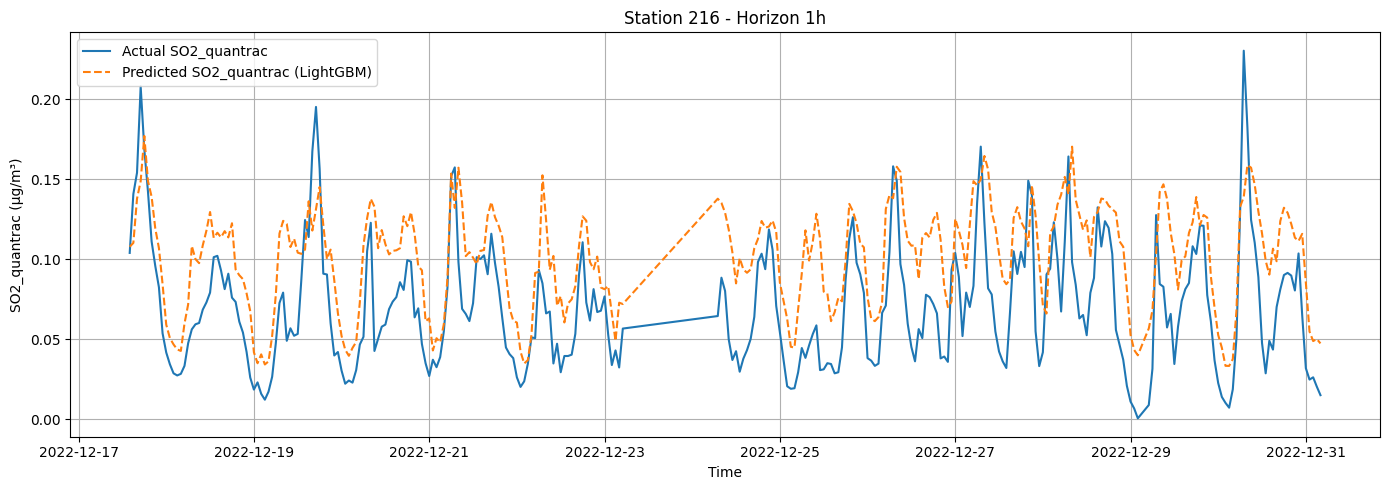

hour = 24


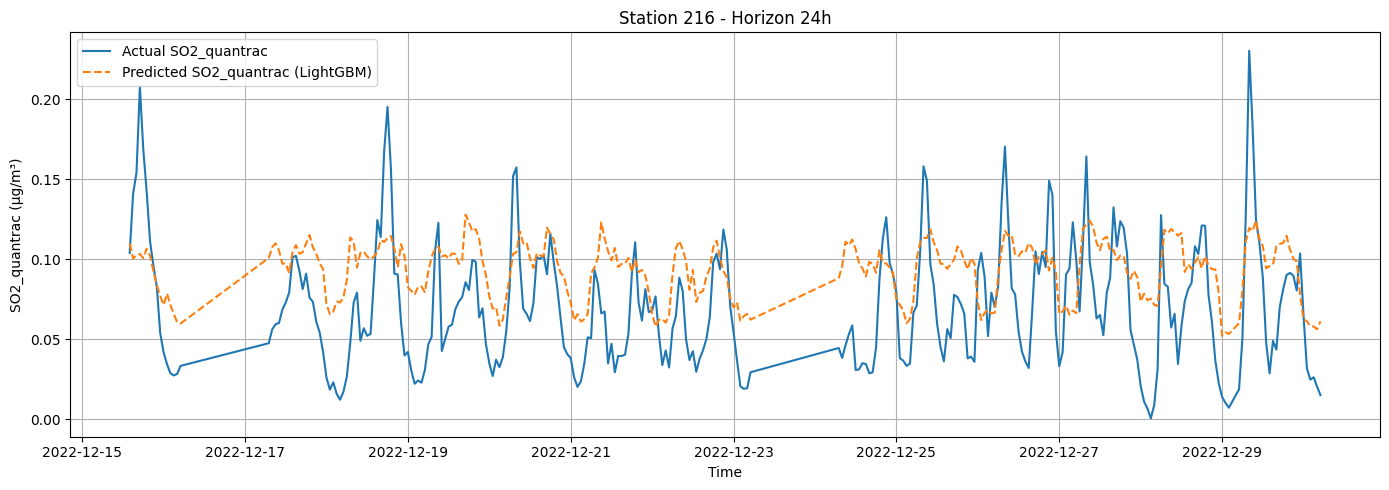

hour = 48


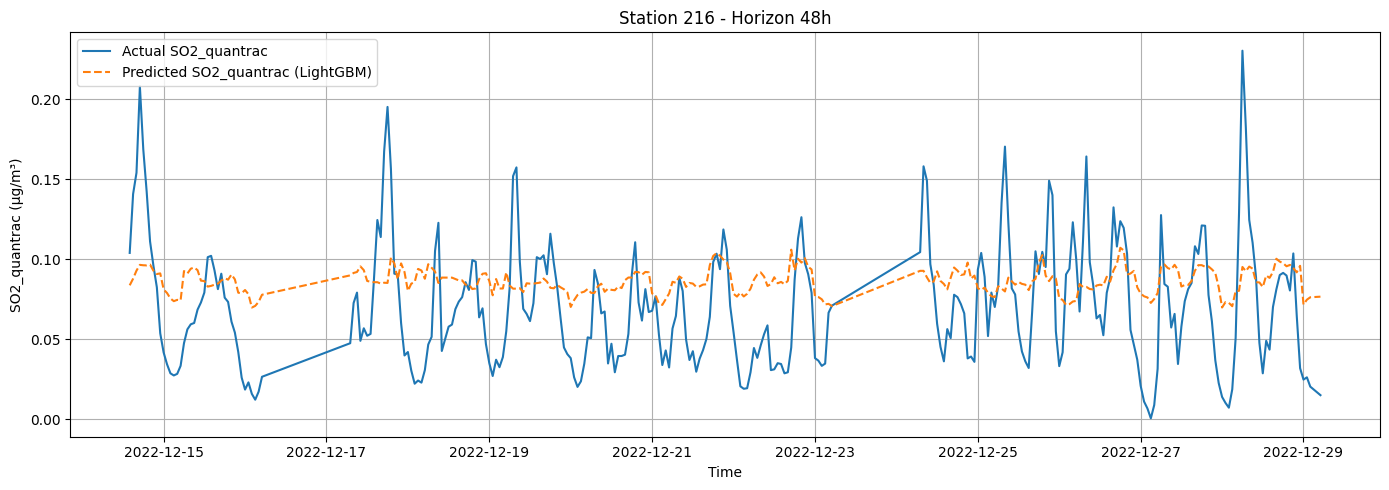

hour = 72


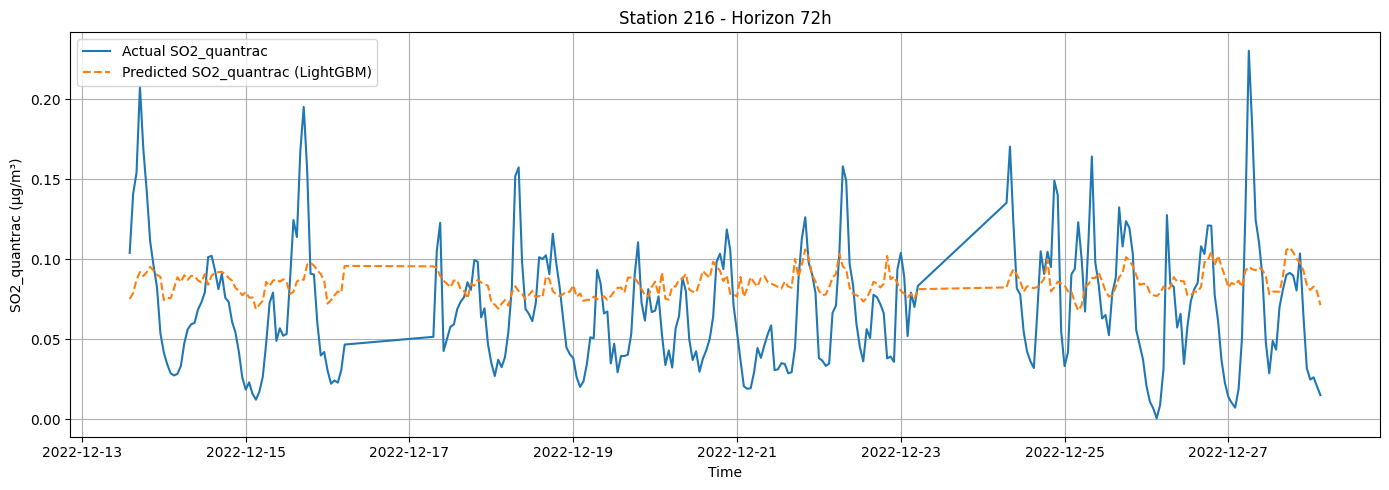

In [22]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label)